In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
import importlib

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error, make_scorer
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder, OrdinalEncoder, FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest

In [4]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor, StackingRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

## Load

In [5]:
df = pd.read_csv("train.csv")
X = df.drop(columns = "SalePrice")
y = df["SalePrice"]

## Preprocessors

In [6]:
id_remover = make_column_transformer(
    ('drop', make_column_selector(pattern='Id')),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

imputer = make_column_transformer(
    (SimpleImputer(strategy='median'), make_column_selector(dtype_exclude=['object', 'string'])),
    (SimpleImputer(strategy='most_frequent'), make_column_selector(dtype_include=['object', 'string'])),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

scaler_num = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number))
).set_output(transform='pandas')

oh_enc = make_column_transformer(
    (OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first', min_frequency=1),
     make_column_selector(dtype_include=['object','string'])),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

# HistGradientBoosting can handle categorial data if it is really encoded as "categorial":
import preprocessing_functions
importlib.reload(preprocessing_functions)
obj_to_cat = preprocessing_functions.ObjToCat()


### Some fancy imputers and encoders.
(Do not seem to improve the score.. Well, the HistGradientBooster has native handling of missing values. Maybe the bigger problem is the overfitting.)

(Missing Values can be explored with the missingno package. But I removed it from here for brevity.)

In [7]:
# maybe, double the size would mean more than double the price.. maybe squared??
# Seems to be unimportant to HistGradientBoost, beause it is a monotonic transformation?
area_poly = make_column_transformer(
    (PolynomialFeatures(include_bias=False, degree=(1,2)),
     make_column_selector(pattern='LotArea')),
    remainder='passthrough',
    verbose_feature_names_out = False
).set_output(transform='pandas')

# Introduce Interaction Term of LotArea|MSZoning, because the area price may be different in different categories..
# Is not so important for HistGradientBoost, but doesn't improve a linear model either..
inter_enc = make_column_transformer(
    (
        make_pipeline(
            make_column_transformer(
                (
                    OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
                    make_column_selector(pattern='MSZoning')
                ),
                remainder='passthrough',
                verbose_feature_names_out=False
            ).set_output(transform='pandas'),
            PolynomialFeatures(degree=(2,2), interaction_only=True, include_bias=False),
            VarianceThreshold()
        ),
        make_column_selector(pattern='LotArea|MSZoning')
    ),
    ('passthrough', make_column_selector(pattern='LotArea|MSZoning')),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

# columns "Condition1" and "Condition2" share their meaning --> reflect this in a single one-hot-encoding
from sklearn.base import BaseEstimator, TransformerMixin
class CondEnc(BaseEstimator, TransformerMixin):
    ### only works to one-hot-encode "Condition1" and "Condition2"
    def __init__(self):
        self.cols = pd.Series([])
        self.cats = np.array([], dtype=str)
        self.ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
    def fit(self, X, y=None):
        self.ohe.fit(X)
        self.cols = pd.Series(self.ohe.transform(X).columns)
        self.cats = self.cols.apply(lambda col: col[11:]) # Remove 'Condition1_' and 'Condition2_' from column names
        self.cats = self.cats.unique()
        return self
    def transform(self, X):
        X_new = self.ohe.transform(X.copy())
        l = []
        for cat in self.cats:
            ll = []
            if 'Condition1_'+cat in list(self.cols): # "in"-opeator does not work as desired with pd.Series --> list()
                ll.append(np.array(X_new['Condition1_'+cat]))
            if 'Condition2_'+cat in list(self.cols):
                ll.append(np.array(X_new['Condition2_'+cat]))
            if len(ll)==2:
                l.append(pd.DataFrame(np.maximum(ll[0], ll[1]), columns=['Condition_'+cat], index=X.index))
            else:
                l.append(pd.DataFrame(ll[0], columns=['Condition_'+cat], index=X.index))
        return pd.concat(l, axis=1)
    def get_feature_names_out(self, input_features=None):
        return [f'Condition_{cat}' for cat in self.cats]
cond_enc = make_column_transformer(
    (CondEnc(), make_column_selector(pattern='Condition1|Condition2')),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

# The documentation says some stuff about missing values.
# The following imputers reflect this:

alley_imp = make_column_transformer(
    (SimpleImputer(strategy='constant', fill_value='None'), make_column_selector(pattern='Alley')),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

masvnr_imp = make_column_transformer(
    (SimpleImputer(strategy='constant', fill_value='None'), make_column_selector(pattern='MasVnrType')),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

bsmt_imp = make_column_transformer(
    (SimpleImputer(strategy='constant', fill_value='None'),
     make_column_selector(pattern='BsmtQual|BsmtCond|BsmtExposure|BsmtFinType1|BsmtFinType2|BsmtFinSF2')),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
lotfrontage_imp= make_column_transformer(
    (IterativeImputer(estimator=KNeighborsClassifier(n_neighbors=30)),
     make_column_selector(pattern="LotArea|LotFrontage")),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

pool_fence_imp = make_column_transformer(
    (SimpleImputer(strategy='constant', fill_value='None'),
     make_column_selector(pattern='PoolQC|Fence')),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

misc_imp = make_column_transformer(
    (SimpleImputer(strategy='constant', fill_value=0),
     make_column_selector(pattern='MiscVal')),
    (SimpleImputer(strategy='constant', fill_value='None'),
     make_column_selector(pattern='MiscFeature')),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

garage_imp = make_column_transformer(
    (SimpleImputer(strategy='constant', fill_value='None'),
     make_column_selector(pattern='GarageType|GarageFinish|GarageQual|GarageCond')),
    (SimpleImputer(strategy='constant', fill_value=0),
     make_column_selector(pattern='GarageYrBlt|GarageCars|GarageArea')),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

fire_imp = make_column_transformer(
    (SimpleImputer(strategy='constant', fill_value='None'),
     make_column_selector(pattern='FireplaceQu')),
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')


# Collect all previous imputers into one:
smart_imps = make_pipeline(fire_imp, alley_imp, masvnr_imp, bsmt_imp,
                           lotfrontage_imp, pool_fence_imp, misc_imp, garage_imp)

## Pipelines

Tried quite a lot. Seems that the pure HistGraientBoost is the best.

Pay attention, if choosing multiple pipes! The steps share objects (instances) for now. (No problem with cross_val_score, because of cloning inside that routine.)

Ideas for improvement:
- Linear models seem to get better with feature selection. But what is the best? (Lasso, SelectKBest, PCA, ...?) Also one could transform non-Gaussian input variables to be more Gaussian.
- The HistGradientBoost seems to overfit a lot. One could use a grid search to tune more parameters. Or build a bagging regressor. But there seems to be a bug in sklearn's BaggingRegressor when used.
- Grid Searches should be done with the scoring function which is also used in Kaggles evaluation.

In [11]:
# My favourite pipe:
pipe15 = make_pipeline(id_remover, smart_imps, cond_enc, imputer, obj_to_cat,
                      TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(categorical_features="from_dtype"),
                                                 func=np.log, inverse_func=np.exp))
# Other pipes, that I tried:
pipe1 = make_pipeline(id_remover, imputer, oh_enc, LinearRegression())
pipe2 = make_pipeline(id_remover, imputer, oh_enc, Ridge())
pipe3 = make_pipeline(id_remover, imputer, oh_enc, Lasso())
pipe4 = make_pipeline(
    id_remover, imputer, oh_enc,
    TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp)
)
pipe5 = make_pipeline(id_remover, imputer, obj_to_cat,
                      HistGradientBoostingRegressor(categorical_features="from_dtype"))
pipe6 = make_pipeline(id_remover, imputer, obj_to_cat,
                      TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(categorical_features="from_dtype"),
                                                 func=np.log, inverse_func=np.exp))
pipe7 = make_pipeline(id_remover, area_poly, imputer, oh_enc, LinearRegression())
pipe8 = make_pipeline(id_remover, area_poly, imputer, obj_to_cat,
                      TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(categorical_features="from_dtype"),
                                                 func=np.log, inverse_func=np.exp))
pipe9 = make_pipeline(inter_enc, id_remover, area_poly, imputer, obj_to_cat,
                      TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(categorical_features="from_dtype"),
                                                 func=np.log, inverse_func=np.exp))
pipe10 = make_pipeline(id_remover, inter_enc, imputer, oh_enc, LinearRegression())
pipe11 = make_pipeline(id_remover, area_poly, imputer, obj_to_cat,
                      HistGradientBoostingRegressor(categorical_features="from_dtype"))
pipe12 = make_pipeline(id_remover, imputer, oh_enc, SVR(kernel='linear'))
pipe13 = StackingRegressor([('GB', pipe6), ('svr', pipe12)])
pipe14 = make_pipeline(id_remover, imputer, scaler_num, oh_enc, MLPRegressor(hidden_layer_sizes=(200,100,50), activation='relu'))
pipe16 = BaggingRegressor(estimator=pipe15, n_estimators=10) # Throws an error. Bug in "BaggingRegressor"?!
pipe17 = make_pipeline(id_remover, smart_imps, cond_enc, imputer, obj_to_cat,
                      TransformedTargetRegressor(regressor=HistGradientBoostingRegressor(categorical_features="from_dtype",
                                                                                         max_features=0.2),
                                                 func=np.log, inverse_func=np.exp))
pipe18 = make_pipeline(id_remover, smart_imps, cond_enc, imputer, oh_enc, Lasso(alpha=100))
pipe19 = make_pipeline(id_remover, smart_imps, cond_enc, imputer, oh_enc, scaler_num,
    VarianceThreshold(0.1), SelectKBest(k=70), Lasso(alpha=10))

## Validate

In [9]:
def print_fit_cv(pipe):
    pipe.fit(X,y)
    fit_score = pipe.score(X,y)
    cv = cross_val_score(pipe, X, y)
    print("Fit_Score: {},   Cv_Mean: {}".format(fit_score, cv.mean()))
print_fit_cv(pipe15)
print_fit_cv(pipe17)

Fit_Score: 0.9887590625353031,   Cv_Mean: 0.8911893068956163
Fit_Score: 0.983430115001647,   Cv_Mean: 0.8905802431044648


## Grid Search

Here is one of the grid searches I ran:
(parameter names can be found out with pipe.get_params())

In [13]:
pipe = pipe19
grid = [{
        'lasso__alpha': [1,10],
        'selectkbest__k': [40, 70]
        }]

gscv = GridSearchCV(pipe, grid, cv = 5)
gscv.fit(X, y)
gscv.cv_results_

c:\Users\User1\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
c:\Users\User1\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [12, 27, 31, 36] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\User1\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
c:\Users\User1\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [8, 12, 34, 36] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\User1\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
c:\Users\User1\anacon

{'mean_fit_time': array([0.92450652, 0.88574076, 0.84200921, 0.81756368]),
 'std_fit_time': array([0.27470538, 0.09404764, 0.14385879, 0.14194987]),
 'mean_score_time': array([0.25894227, 0.26645255, 0.23429098, 0.23226199]),
 'std_score_time': array([0.05944122, 0.04989727, 0.06256571, 0.10566529]),
 'param_lasso__alpha': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_selectkbest__k': masked_array(data=[40, 70, 40, 70],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lasso__alpha': 1, 'selectkbest__k': 40},
  {'lasso__alpha': 1, 'selectkbest__k': 70},
  {'lasso__alpha': 10, 'selectkbest__k': 40},
  {'lasso__alpha': 10, 'selectkbest__k': 70}],
 'split0_test_score': array([0.79986828, 0.85064227, 0.79993758, 0.85084412]),
 'split1_test_score': array([0.75286713, 0.78015659, 0.75282497, 0.78047556]),
 'split2_test_score': array

Print CV-Results:

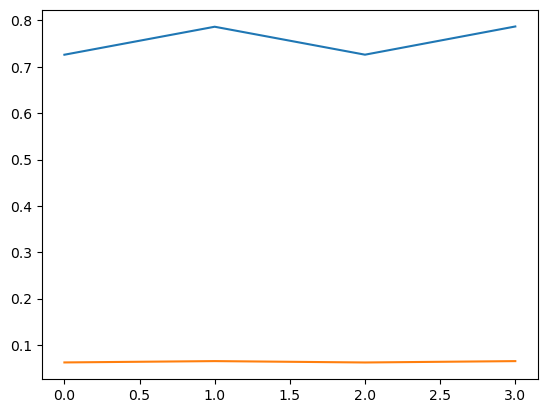

In [15]:
stds = gscv.cv_results_['std_test_score']
means = gscv.cv_results_['mean_test_score']
import matplotlib.pyplot as plt
plt.plot(means)
plt.plot(stds)

## Submission to Kaggle

In [18]:
pipe = pipe15
pipe.fit(X,y)
df_submission = pd.read_csv("test.csv")
df_submission = pd.DataFrame({"Id": df_submission["Id"],
                              "SalePrice": pipe.predict(df_submission)})
df_submission.to_csv("submission.csv", index = False)